# Eddy Kinetic Energy from ADT

#### Module import and dask cluster

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import dask
import cartopy
import cartopy.crs as ccrs
import datetime

from dask.distributed import Client

In [2]:
# Make sure the Dask dashboard is easy to reach
dask.config.set(
    {
        'distributed.dashboard.link':
        "{JUPYTERHUB_BASE_URL}user/{JUPYTERHUB_USER}/proxy/{port}/status"
    }
)

In [3]:
client = Client(n_workers=1, threads_per_worker=2, memory_limit=6e9)
client

Client Scheduler: tcp://127.0.0.1:39373 Dashboard: /user/ws20pherproj_eke/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 6.00 GB


#### Open dataset

In [4]:
ds = xr.open_zarr("/course_materials/ws20pherproj_eke_data/SLTAC_GLO_PHY_L4_REP_v2.x.x.zarr/")

#### Define functions to calculate geostrophic surface velocities

\begin{equation}
u = - \frac{g}{f} \frac{\partial \zeta}{\partial y}; \qquad
v =\frac{g}{f} \frac{\partial \zeta}{\partial x} 
\end{equation}

Take into account that meridians converge towards the pole.

In [5]:
def get_u_from_adt(adt):
    '''
    Calculates eastward velocity u from 0.25° x 0.25° gridded absolute dynamic topography.
    '''
        
    dzeta = adt.diff('latitude') 
    y_deg = adt.coords['latitude']
    
    y = y_deg * 111e3 
    dy = y.diff('latitude')
    dzeta_dy = dzeta / dy
    
    g = 9.81
    omega = 2 * np.pi / (24*60*60)
    f = 2 * omega * np.sin(np.radians(y_deg))
    
    u = - g/f * dzeta_dy
    return u

In [6]:
def get_v_from_adt(adt):
    '''
    Calculates northward velocity v from 0.25° x 0.25° gridded absolute dynamic topography.
    '''
    dzeta = adt.diff('longitude') 
    x_deg = adt.coords['longitude']
    y_deg = adt.coords['latitude']
    
    x = x_deg * np.cos(np.radians(y_deg)) * 111e3
    dx = x.diff('longitude')
    dx = dx[0,:]
    dzeta_dx = dzeta / dx
    
    g = 9.81
    omega = 2 * np.pi / (24*60*60)
    f = 2 * omega * np.sin(np.radians(y_deg))
    
    v = g/f * dzeta_dx
    return v

#### Mask land and ice

Mask any grid point which is covered by ice or land at some time step during the time series. 

In [7]:
mask = ds.adt.isnull().sum('time').compute()

def mask_array(arr):
    return arr.where(mask == 0)

## Global EKE map

#### Calculate velocities

In [8]:
u = get_u_from_adt(ds.adt)
v = get_v_from_adt(ds.adt)

In [9]:
u = u.chunk({"time": 100})
v = v.chunk({"time": 100})

#### Calculate EKE as monthly resample

In [10]:
eke = 0.5 * (
                ((u ** 2).resample(time='MS').mean('time').groupby('time.month') 
                - u.groupby('time.month').mean('time') ** 2)
                + ((v ** 2).resample(time='MS').mean('time').groupby('time.month') 
                - v.groupby('time.month').mean('time') ** 2)
)

In [11]:
eke = eke.compute()

In [12]:
# Mask near-equator region, mask land and ice surfaces and convert EKE m²/s² -> cm²/s²
eke = mask_array(eke)
eke = eke.where(abs(eke.coords["latitude"]) > 5)
eke = eke * 100**2

Convert seasonal averaged EKE into velocity equivalent eke_vel

In [13]:
eke_avg_season = eke.groupby('time.season').mean()
eke_vel = (2*eke_avg_season)**0.5

Seasonal average of ADT for contourlines of the plot

In [14]:
adt_avg_season = ds.adt.groupby('time.season').mean('time')
adt_avg_season = adt_avg_season.compute()

/opt/tljh/user/envs/ws20pherproj_eke/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/opt/tljh/user/envs/ws20pherproj_eke/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[k

#### Create figure

Text(0.5, 0.95, 'Velocity equivalent of Eddy Kinetic Energy')

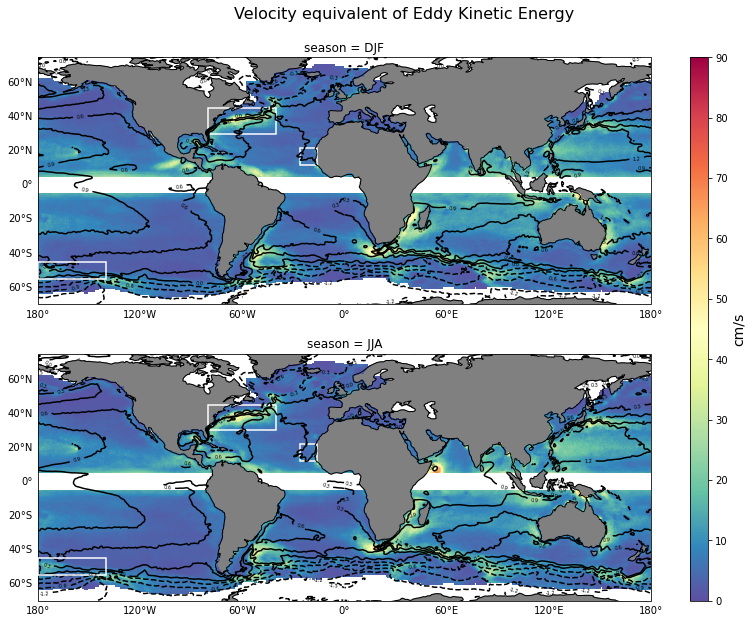

In [15]:
 season_list = ["DJF", "JJA"]

fig = plt.figure(figsize=(14,10))
ax = fig.subplots(nrows=2,ncols=1,
                    subplot_kw={'projection': ccrs.PlateCarree()})
ax=ax.flatten()

for i,s in enumerate(season_list):
    ax[i].set_extent([-180,180,-70,75], crs=ccrs.PlateCarree())
    ax[i].coastlines()
    gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha = 0) 
    gl.top_labels = False
    gl.right_labels = False
    ax[i].add_feature(cartopy.feature.LAND, color='grey')
    im = eke_vel.sel(season=s).plot(ax = ax[i], add_colorbar = False, cmap = 'Spectral_r', rasterized = True, vmin = 0, vmax = 90)
    adt_iso = adt_avg_season.sel(season=s).plot.contour(ax = ax[i], colors='k', levels = np.linspace(-1.5,1.5,11))
    plt.clabel(adt_iso, fontsize=5, inline=1, fmt='%1.1f')
    
    ax[i].add_patch(mpatches.Rectangle(xy=[-80,30], width=40, height=15,
                                    fill = False,
                                    edgecolor = 'white',
                                    linewidth = 1.5,
                                    transform=ccrs.PlateCarree())
                 )
    ax[i].add_patch(mpatches.Rectangle(xy=[-180,-55], width=40, height=10,
                                    fill = False,
                                    edgecolor = 'white',
                                    linewidth = 1.5,
                                    transform=ccrs.PlateCarree(), zorder = 3)
                 )
    ax[i].add_patch(mpatches.Rectangle(xy=[-26,12], width=10, height=10,
                                    fill = False,
                                    edgecolor = 'white',
                                    linewidth = 1.5,
                                    transform=ccrs.PlateCarree())
                 )
    
cbar = fig.colorbar(im, ax=ax, orientation='vertical', aspect = 30);
cbar.set_label('cm/s', fontsize = 14)
fig.suptitle('Velocity equivalent of Eddy Kinetic Energy', fontsize = 16, y=0.95)
#plt.savefig('eke-global-djf-jja-5.pdf', bbox_inches = 'tight', pad_inches = 0)

## Somali current map

#### Calculate velocities

In [16]:
extent = [45,62,4,20]
u = get_u_from_adt(ds.adt.sel(longitude = slice(extent[0],extent[1]), latitude = slice(extent[2],extent[3])))
v = get_v_from_adt(ds.adt.sel(longitude = slice(extent[0],extent[1]), latitude = slice(extent[2],extent[3])))

#### Calculate EKE with a moving average of 90 days

For axis 0, 1, 4, 5

In [17]:
eke= (
    (
        (u.chunk({"time": -1, "latitude": 10, "longitude": 10}) ** 2).rolling(time=90, center=True).mean()
        - u.chunk({"time": -1, "latitude": 10, "longitude": 10}).rolling(time=90, center=True).mean() ** 2
        +(v.chunk({"time": -1, "latitude": 10, "longitude": 10}) ** 2).rolling(time=90, center=True).mean()
        - v.chunk({"time": -1, "latitude": 10, "longitude": 10}).rolling(time=90, center=True).mean() ** 2
    ) / 2
    );
eke = eke.compute()

In [18]:
# Mask near-equator region and convert EKE m²/s² -> cm²/s²
    
eke = eke.where(abs(eke.coords["latitude"]) > 3)
eke = eke * 100**2 # in cm²/s²

Convert seasonal averaged EKE into velocity equivalent eke_vel

In [19]:
eke_avg_season = eke.groupby('time.season').mean()
eke_vel = ((2*eke_avg_season)**0.5)

Seasonal average of ADT for contourlines of the plot

In [20]:
adt = ds.adt.sel(longitude = slice(extent[0],extent[1]), 
                 latitude = slice(extent[2],extent[3])
                ).mean('time')

In [21]:
adt_avg_season = ds.adt.sel(longitude = slice(extent[0],extent[1]), 
                            latitude = slice(extent[2],extent[3])
                           ).groupby('time.season').mean('time')

#### Calculate EKE with respect to the entire time series

For axis 2

In [22]:
um = get_u_from_adt(ds.adt.sel(longitude = slice(extent[0],extent[1]), latitude = slice(extent[2],extent[3])))
vm = get_v_from_adt(ds.adt.sel(longitude = slice(extent[0],extent[1]), latitude = slice(extent[2],extent[3])))

eke2= ((um**2).mean('time') 
        - um.mean('time')**2
      +(vm**2).mean('time') 
        - vm.mean('time')**2)/2
eke2 = eke2.compute()
    
eke2 = eke2.where(abs(eke.coords["latitude"]) > 3)
eke2 = eke2 * 100**2 # in cm²/s²
eke_vel2 = ((2*eke2)**0.5)

#### Create figure

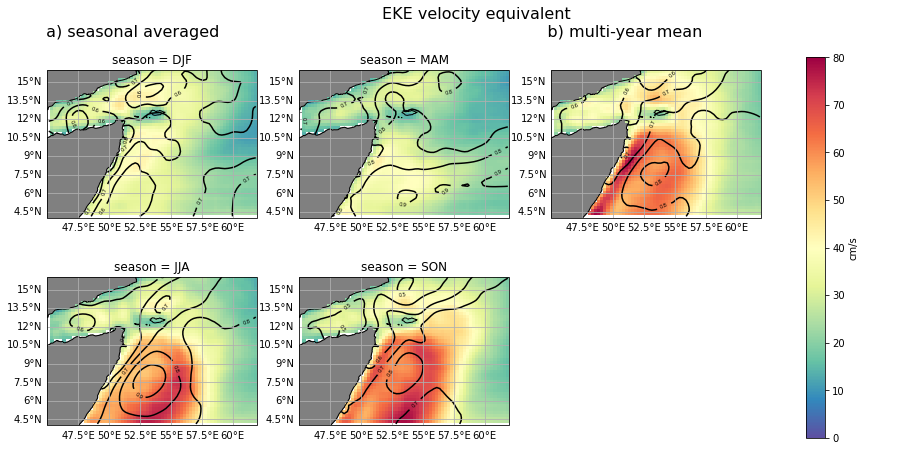

In [23]:
season_list = ["DJF", "MAM", "JJA", "SON", '', '']

fig = plt.figure(figsize=(16,7))
ax = fig.subplots(nrows=2,ncols=3,subplot_kw={'projection': ccrs.PlateCarree()})
ax=ax.flatten()
extent = [45,62,4,16]
for i,s in enumerate(season_list):
    if i <4:
        if i==2 or i == 3: i = i +1
        ax[i].coastlines()
        gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False
        ax[i].add_feature(cartopy.feature.LAND, color='grey')
        ax[i].set_extent(extent, crs=ccrs.PlateCarree())
        im = eke_vel.sel(season=s).plot(ax = ax[i], cmap = 'Spectral_r', rasterized=True, add_colorbar = False, vmin = 0, vmax = 80)
        adt_iso = adt_avg_season.sel(season=s).plot.contour(ax = ax[i], colors='k')
        plt.clabel(adt_iso, fontsize=5, inline=1, fmt='%1.1f')
        ax[i].set_rasterized(True)

ax[2].coastlines()
gl = ax[2].gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax[2].add_feature(cartopy.feature.LAND, color='grey')
ax[2].set_extent(extent, crs=ccrs.PlateCarree())
im = eke_vel2.plot(ax = ax[2], cmap = 'Spectral_r', rasterized=True, add_colorbar = False, vmin = 0, vmax = 80)
adt_iso = adt.plot.contour(ax = ax[2], colors='k')
plt.clabel(adt_iso, fontsize=5, inline=1, fmt='%1.1f')
ax[2].set_rasterized(True)
plt.title('')
        
ax[5].set_visible(False)
    
region = 'Somali current (5°-12°N, 45°-60°E)'
fig.suptitle('EKE velocity equivalent \n a) seasonal averaged                                                                b) multi-year mean                                          ', fontsize = 16)
cbar = fig.colorbar(im, ax=ax);
cbar.set_label('cm/s')
#plt.savefig('eke-vel_somali-90d-3.pdf', bbox_inches = 'tight', pad_inches = 0)

## Seasonal Cycle

#### Gulf Stream

In [24]:
extent = [280,320,30,45]

u = get_u_from_adt(ds.adt.sel(longitude = slice(extent[0],extent[1]), latitude = slice(extent[2],extent[3])))
v = get_v_from_adt(ds.adt.sel(longitude = slice(extent[0],extent[1]), latitude = slice(extent[2],extent[3])))


In [25]:
eke= (
    (
        (u.chunk({"time": -1, "latitude": 10, "longitude": 10}) ** 2).rolling(time=90, center=True).mean()
        - u.chunk({"time": -1, "latitude": 10, "longitude": 10}).rolling(time=90, center=True).mean() ** 2
        +(v.chunk({"time": -1, "latitude": 10, "longitude": 10}) ** 2).rolling(time=90, center=True).mean()
        - v.chunk({"time": -1, "latitude": 10, "longitude": 10}).rolling(time=90, center=True).mean() ** 2
    ) / 2
    )
eke = eke.compute()

    
eke = eke.where(abs(eke.coords["latitude"]) > 5)


In [26]:
# Weighting matrix: A weighting factor is assigned to each element != NaN depending on latitude.
weighting = ((eke.isnull()^1).T * np.cos(np.radians(eke.coords['latitude'].values))).T

# Area average and conversion and EKE m²/s² -> cm²/s²
eke_avg=(eke*weighting).mean('latitude').mean('longitude')*100**2

In [27]:
eke_avg_month = eke_avg.groupby('time.month').mean('time')
eke_std_month = eke_avg.groupby('time.month').std('time')

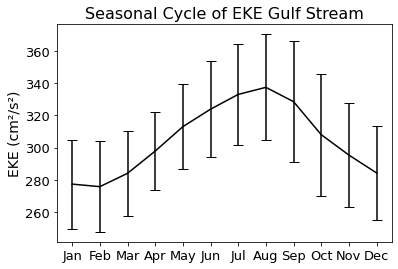

In [28]:
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13

fig = plt.figure()
ax = fig.add_subplot()
ax.errorbar(np.arange(len(eke_avg_month)), eke_avg_month, yerr = eke_std_month, capsize=5, color = 'k')
ax.set_ylabel('EKE (cm²/s²)', fontsize=14) 
ax.set_title('Seasonal Cycle of EKE Gulf Stream', fontsize = 16)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(months);
#plt.savefig('seascycl_eke_GS-2.pdf', bbox_inches = 'tight', pad_inches = 0.05)  

#### ACC

In [29]:
extent = [185,225,-55,-45]#[185,225,-60,-55]

u = get_u_from_adt(ds.adt.sel(longitude = slice(extent[0],extent[1]), latitude = slice(extent[2],extent[3])))
v = get_v_from_adt(ds.adt.sel(longitude = slice(extent[0],extent[1]), latitude = slice(extent[2],extent[3])))

In [30]:
eke= (
    (
        (u.chunk({"time": -1, "latitude": 10, "longitude": 10}) ** 2).rolling(time=90, center=True).mean()
        - u.chunk({"time": -1, "latitude": 10, "longitude": 10}).rolling(time=90, center=True).mean() ** 2
        +(v.chunk({"time": -1, "latitude": 10, "longitude": 10}) ** 2).rolling(time=90, center=True).mean()
        - v.chunk({"time": -1, "latitude": 10, "longitude": 10}).rolling(time=90, center=True).mean() ** 2
    ) / 2
    );
eke = eke.compute()

eke = eke.where(abs(eke.coords["latitude"]) > 5)


In [31]:
# Weighting matrix: A weighting factor is assigned to each element != NaN depending on latitude.
weighting = ((eke.isnull()^1).T * np.cos(np.radians(eke.coords['latitude'].values))).T

# Area average and conversion EKE m²/s² -> cm²/s²
eke_avg=(eke*weighting).mean('latitude').mean('longitude')*100**2

In [32]:
eke_avg_month = eke_avg.groupby('time.month').mean('time')
eke_std_month = eke_avg.groupby('time.month').std('time')

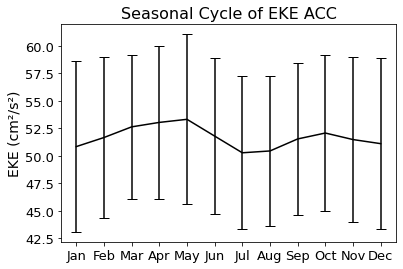

In [33]:
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13

fig = plt.figure()
ax = fig.add_subplot()
ax.errorbar(np.arange(len(eke_avg_month)), eke_avg_month, yerr = eke_std_month, capsize=5, color = 'k')
ax.set_ylabel('EKE (cm²/s²)', fontsize=14) 
ax.set_title('Seasonal Cycle of EKE ACC', fontsize = 16)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(months);
#plt.savefig('seascycl_eke_ACC-3.pdf', bbox_inches = 'tight',pad_inches = 0.05) 

#### Cape Verde region

In [34]:
extent = [334,344,12,22]
u = ds.ugos.sel(longitude = slice(extent[0],extent[1]), latitude = slice(extent[2],extent[3]))
v = ds.vgos.sel(longitude = slice(extent[0],extent[1]), latitude = slice(extent[2],extent[3]))

In [35]:
eke= (
    (
        (u ** 2).rolling(time=90, center=True).mean()
        - u.rolling(time=90, center=True).mean() ** 2
        +(v ** 2).rolling(time=90, center=True).mean()
        - v.rolling(time=90, center=True).mean() ** 2
    ) / 2
    );
eke = eke.compute()

eke = eke.where(abs(eke.coords["latitude"]) > 5)

In [36]:
# Weighting matrix: A weighting factor is assigned to each element != NaN depending on latitude.
weighting = ((eke.isnull()^1) * np.cos(np.radians(eke.coords['latitude'].values))).T

# Area average and conversion and EKE m²/s² -> cm²/s²
eke_avg=(eke*weighting).mean('latitude').mean('longitude')*100**2

In [46]:
eke_avg_month = eke_avg.groupby('time.month').mean('time')
eke_std_month = eke_avg.groupby('time.month').std('time')

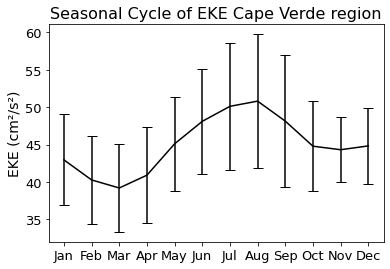

In [47]:
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13

fig = plt.figure()
ax = fig.add_subplot()
ax.errorbar(np.arange(len(eke_avg_month)), eke_avg_month, yerr = eke_std_month, capsize=5, color = 'k')
ax.set_ylabel('EKE (cm²/s²)', fontsize=14) 
ax.set_title('Seasonal Cycle of EKE Cape Verde region', fontsize = 16)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(months);
#plt.savefig('seascycl_eke_TropNEAtlantic-2.pdf', bbox_inches = 'tight', pad_inches = 0.05) 